In [2]:
!pip install torch
!pip install numpy
!pip install pandas
!Pip install matplotlib
!pip install scikit-learn


In [5]:
import zipfile
import os

zip_file_path = '/Users/paramanandbhat/Downloads/train-scene classification.zip'  # Example path to your zip file
extraction_directory = '/Users/paramanandbhat/Downloads/train_scene'  # Example path where you want to extract the files



In [6]:
# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print("Extraction completed.")

Extraction completed.


In [8]:
!pip install pyarrow
import pandas as pd

from PIL import Image
import numpy as np
import os


  Using cached pyarrow-15.0.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (3.0 kB)
Using cached pyarrow-15.0.0-cp39-cp39-macosx_11_0_arm64.whl (24.2 MB)


In [11]:
csv_file_path = os.path.join(extraction_directory, 'train.csv')
# Load the CSV file containing the labels
data = pd.read_csv(csv_file_path)

data.head()


,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [12]:
extraction_directory_images = '/Users/paramanandbhat/Downloads/train_scene/train/'

#  image files are directly in the extraction directory, update if they are in a subdirectory
def load_image(image_name):
    image_path = os.path.join(extraction_directory_images, image_name)
    with Image.open(image_path) as img:
        return np.array(img)


In [13]:
# Load the images based on the image_name column in the CSV
data['image'] = data['image_name'].apply(load_image)

print("Data loading completed.")

Data loading completed.


In [16]:
!pip install scikit-image


from skimage.transform import resize
# Function to normalize and resize an image
def preprocess_image(image, target_size=(128, 128)):
    """
    Normalize pixel values to the range 0-1 and resize the image to a uniform size.
    
    Parameters:
    - image: numpy array, the image to be processed.
    - target_size: tuple, the target size (width, height) of the image.
    
    Returns:
    - Processed image as a numpy array.
    """
    # Normalize pixel values to 0-1
    normalized_image = image.astype('float32') / 255.0
    
    # Resize image
    resized_image = resize(normalized_image, target_size, anti_aliasing=True)
    
    return resized_image

# Apply the preprocessing function to each image in the DataFrame
data['processed_image'] = data['image'].apply(lambda x: preprocess_image(x))

print("Data pre-processing completed.")

Data pre-processing completed.


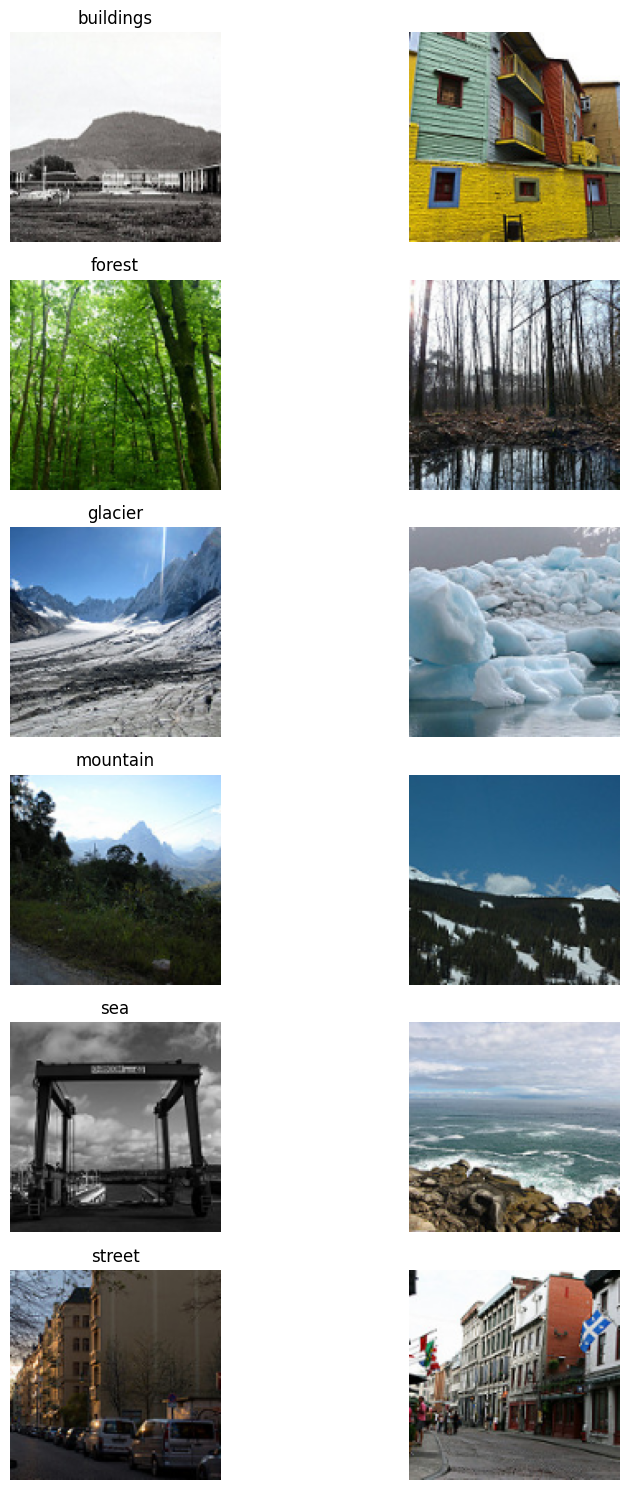

In [17]:
import matplotlib.pyplot as plt
# Sample data simulation (replace with actual 'data' DataFrame in your environment)
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
images_per_category = 2  # Number of images to display per category
data_demo = pd.DataFrame(data)

# Plotting
fig, axes = plt.subplots(len(categories), images_per_category, figsize=(10, 15))

for i, category in enumerate(categories):
    # Filter the dataset for the current category
    category_data = data_demo[data_demo['label'] == i].head(images_per_category)
    
    for j, (_, row) in enumerate(category_data.iterrows()):
        ax = axes[i, j]
        ax.imshow(row['processed_image'], cmap='gray')
        ax.axis('off')
        
        if j == 0:
            ax.set_title(category)

plt.tight_layout()
plt.show()

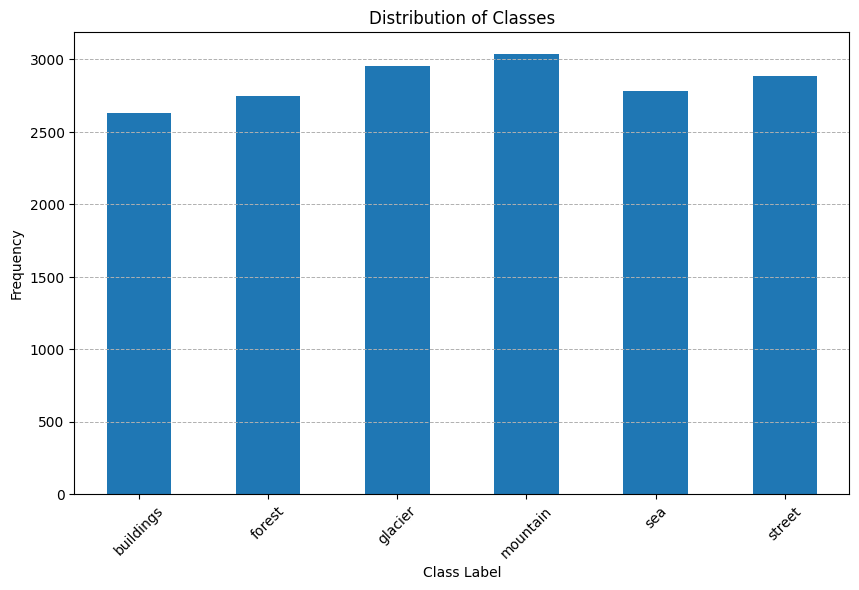

In [19]:
# Analyzing the distribution of classes
class_distribution = data['label'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Classes')
plt.xticks(ticks=range(len(categories)), labels=categories, rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

In [20]:
# Checking for imbalances
print("Class distribution:\n", class_distribution)

Class distribution:
 label
0    2628
1    2745
2    2957
3    3037
4    2784
5    2883
Name: count, dtype: int64


In [21]:
imbalance_check = class_distribution.std() / class_distribution.mean()
print(f"\nImbalance metric (std/mean): {imbalance_check:.2f}")
if imbalance_check > 0.5:
    print("Significant class imbalance detected. Consider using strategies like oversampling or undersampling.")
else:
    print("Minor imbalances detected. The dataset is relatively balanced.")


Imbalance metric (std/mean): 0.05
Minor imbalances detected. The dataset is relatively balanced.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    # Convolutional layer with 32 filters, a kernel size of 3, ReLU activation, and input shape defined
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # Update input_shape based on your data
    MaxPooling2D(2, 2),
    
    # Second convolutional layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Third convolutional layer with 128 filters
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flatten the output of the convolutional layers
    Flatten(),
    
    # Dense (fully connected) layer with dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Output layer with softmax activation for multi-class classification
    Dense(6, activation='softmax')  # Update the number of neurons to match the number of classes in your dataset
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [23]:
from sklearn.model_selection import train_test_split

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
labels = to_categorical(data['label'])

# Splitting the dataset into training and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    np.array(data_demo['processed_image'].tolist()),  # Ensuring the image data is in the correct format
    labels,  # Using the potentially one-hot encoded labels
    test_size=0.4,
    random_state=42,
    stratify=labels
)


In [28]:
# Splitting the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)


In [30]:
# Number of epochs to train the model
epochs = 10

# Batch size for training
batch_size = 32

# Training the model
history = model.fit(
    X_train,  # Training data
    y_train,  # Labels for the training data
    epochs=epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size
    validation_data=(X_val, y_val),  # Validation data
    verbose=1  # Show training log
)



Epoch 1/10
320/320 [==============================] - 53s 164ms/step - loss: 1.1230 - accuracy: 0.5536 - val_loss: 0.8697 - val_accuracy: 0.6616
Epoch 2/10
320/320 [==============================] - 56s 176ms/step - loss: 0.8575 - accuracy: 0.6770 - val_loss: 0.8036 - val_accuracy: 0.7062
Epoch 3/10
320/320 [==============================] - 57s 177ms/step - loss: 0.7228 - accuracy: 0.7436 - val_loss: 0.6446 - val_accuracy: 0.7731
Epoch 4/10
320/320 [==============================] - 57s 179ms/step - loss: 0.6120 - accuracy: 0.7850 - val_loss: 0.5489 - val_accuracy: 0.8119
Epoch 5/10
320/320 [==============================] - 57s 179ms/step - loss: 0.5112 - accuracy: 0.8216 - val_loss: 0.5554 - val_accuracy: 0.8213
Epoch 6/10
320/320 [==============================] - 64s 200ms/step - loss: 0.4646 - accuracy: 0.8397 - val_loss: 0.5490 - val_accuracy: 0.8089
Epoch 7/10
320/320 [==============================] - 60s 187ms/step - loss: 0.3936 - accuracy: 0.8601 - val_loss: 0.5395 - val_ac

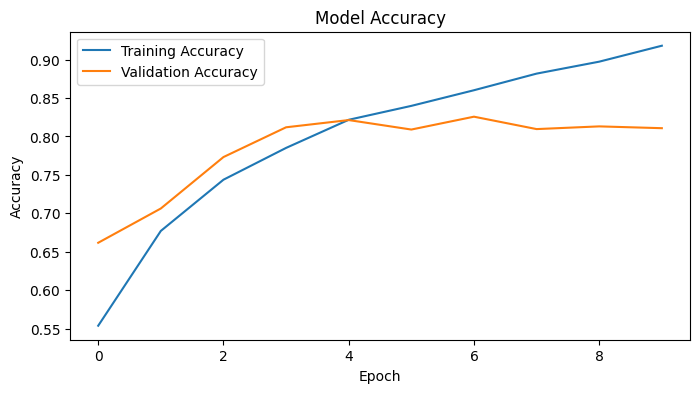

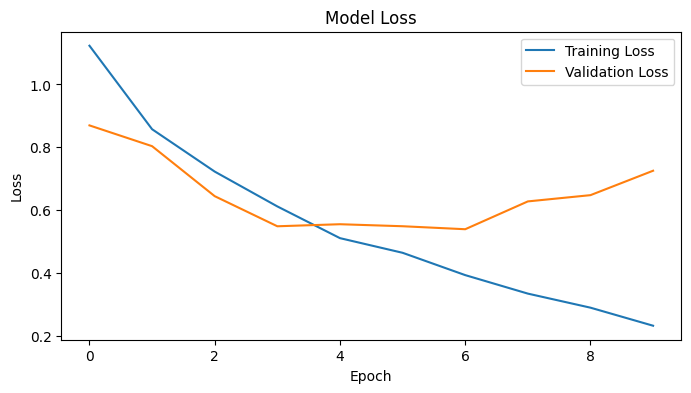

In [31]:
# Plotting the training history
import matplotlib.pyplot as plt
# Accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [43]:
#Loading the test data 
import pandas as pd
from PIL import Image
import numpy as np
import os

# Load the test data CSV
test_csv_path = '/Users/paramanandbhat/Downloads/test_hAjxzwh.csv'
images_dir = '/Users/paramanandbhat/Downloads/train_scene/train/'
test_data = pd.read_csv(test_csv_path)

from PIL import Image
import numpy as np
import os

def preprocess_image(image_path, target_size=(128, 128)):
    """
    Load an image from its path, normalize pixel values to the range 0-1,
    and resize the image to a uniform size. Ensure the image is in RGB format.
    
    Parameters:
    - image_path: str, path to the image file.
    - target_size: tuple, the target size (width, height) of the image.
    
    Returns:
    - Processed image as a numpy array.
    """
    with Image.open(image_path) as img:
        # Convert image to RGB
        img = img.convert('RGB')
        img = img.resize(target_size)  # Resize image
        img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values
    
    return img_array





In [44]:
# Preprocess images
test_data['processed_image'] = test_data['image_name'].apply(lambda x: preprocess_image(os.path.join(images_dir, x)))
print(test_data.columns)

Index(['image_name', 'processed_image'], dtype='object')


In [45]:
# Convert processed images to a format suitable for the model
X_test = np.array(test_data['processed_image'].tolist())


In [52]:

# Predict and store the numeric labels
predictions = model.predict(X_test)

229/229 [==============================] - 10s 41ms/step


In [47]:
predicted_labels = np.argmax(predictions, axis=1)
test_data['predicted_label'] = predicted_labels

In [48]:
print("Test data with numeric predictions:")
print(test_data.head())

Test data with numeric predictions:
  image_name                                    processed_image  \
0      3.jpg  [[[0.17254902, 0.17254902, 0.17254902], [0.235...   
1      5.jpg  [[[0.54901963, 0.53333336, 0.67058825], [0.549...   
2      6.jpg  [[[0.5411765, 0.69411767, 0.79607844], [0.5333...   
3     11.jpg  [[[0.043137256, 0.043137256, 0.043137256], [0....   
4     14.jpg  [[[0.84705883, 0.7882353, 0.7058824], [0.84313...   

   predicted_label  
0                5  
1                0  
2                4  
3                2  
4                5  


In [51]:
# Now, save this DataFrame to a CSV file

output_csv_path = '/Users/paramanandbhat/Downloads/train_scene/output_predictions.csv'  # Specify your desired output path

# Save the DataFrame to CSV
test_data[['image_name', 'predicted_label']].to_csv(output_csv_path, index=False)

print(f"Predictions saved to {output_csv_path}")


Predictions saved to /Users/paramanandbhat/Downloads/train_scene/output_predictions.csv


In [53]:
# Rename 'predicted_label' column to 'label'
test_data.rename(columns={'predicted_label': 'label'}, inplace=True)

# Specify the output path for the CSV file
output_csv_path = '/Users/paramanandbhat/Downloads/train_scene/output_predictions.csv'# Save the DataFrame with the renamed column to CSV
test_data[['image_name', 'label']].to_csv(output_csv_path, index=False)

print(f"Predictions (with 'label') saved to {output_csv_path}")


Predictions (with 'label') saved to /Users/paramanandbhat/Downloads/train_scene/output_predictions.csv
